In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from keras.optimizers import SGD, Adam, RMSprop, Adamax, Adadelta
from keras.models import Model, load_model
from keras import Input
from keras.layers import Dense, Dropout, Multiply, concatenate, LeakyReLU
from matplotlib import pyplot as plt
import keras.backend as K
from sklearn.preprocessing import StandardScaler
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback
from sklearn.preprocessing import quantile_transform
import psycopg2
import missingno as msno

Using TensorFlow backend.


In [110]:
# Network Definition
def custom_loss(y_true,y_pred):
        # M * R * G
        # (1-w *R) * R * G
        weights = y_pred[:,0]
        g_i = y_pred[:,1]
        excess_returns = y_true
        M = 1-K.sum(weights * excess_returns)
        custom_loss_value = K.mean((M * excess_returns * g_i)**2)
        return custom_loss_value
# model = load_model('model.h5', 
#                    custom_objects={'loss': asymmetric_loss(alpha)})

def loss_arguments(Tickers, i):
    observation_weights =\
    Tickers["Count"].iloc[i*128:i*128+128]/\
    Tickers["Count"].iloc[i*128:i*128+128].sum()
    def custom_loss(y_true,y_pred):
        # M * R * G
        # (1-w *R) * R * G
        weights = y_pred[:,0]
        g_i = y_pred[:,1]
        excess_returns = y_true
        M = 1-K.sum(weights * excess_returns)
        custom_loss_value = K.mean((M * excess_returns * g_i)**2)
        return custom_loss_value
    return custom_loss_value


def custom_loss_adverse(y_true, y_pred):
    # M * R * G
    # (1-w *R) * R * G
    weights = y_pred[:,0]
    g_i = y_pred[:,1]
    excess_returns = y_true
    M = 1-K.sum(weights * excess_returns)
    custom_loss_value = - K.mean((M * excess_returns * g_i)**2)
    return custom_loss_value

class CustomCallback(Callback):
    def on_train_batch_end(self, batch, logs=None):
        global i
        global Tickers
        
        observation_weights_ =\
        Tickers["Count"].iloc[i*128:i*128+128]/\
        Tickers["Count"].iloc[i*128:i*128+128].sum()        
        i = i+1
        #print(observation_weights_)

In [238]:
input_shape

(438,)

In [260]:
input_shape = (491,)
network=None
opt=Adamax(lr=0.001)
    
    
Input_object = Input(shape =input_shape, name='Input', dtype='float32')
Dense1 = Dense(50, activation='sigmoid', name='Dense1', input_shape=input_shape)(Input_object)
Dropout1= Dropout(0.05)(Dense1)
Dense2 = Dense(50, activation='sigmoid', name='Dense2')(Dropout1)
Dense3 = Dense(1, activation='sigmoid', name='Dense3')(Dense2)
#LeakyReLU
G_1 = Dense(50, activation='sigmoid', name='G_1', input_shape=input_shape)(Input_object)

# Sigmoid works
G_2 = Dense(1, activation='sigmoid', name='G_2')(G_1)

Out = concatenate([Dense3, G_2], name='Output')

# X_features_set = X
# Y_features_set = np.array(Y)
# x_features_set = X[0:1000]
# y_features_set = np.array(Y[0:1000])
network = Model([Input_object], Out)

In [170]:
# database cols: needed only once

conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=password")
cur = conn.cursor()

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'data');")
column_names = cur.fetchall()
print("got column_names")

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'macro');")
macro_column_names = cur.fetchall()
print("got macro_column_names")

cur.execute("SELECT * From macro;")
macro_data = cur.fetchall()
macro_data = pd.DataFrame(macro_data, columns=pd.DataFrame(macro_column_names)[0])

print("got macro_data")

conn.commit()
cur.close()
conn.close()


got column_names
got macro_column_names
got macro_data


In [171]:
variables=pd.read_excel("PATH\\Output\\variables_small.xlsx",\
                  sheet_name = "variables", usecols = "A:B")
identifiers=variables[(variables["TYPE"]=="identifier") | (variables["TYPE"]=="observation identifier")]
identifiers=list(identifiers["VARIABLE"])
identifiers.remove("eom")

delete_cols = pd.read_csv("Networks\delete_cols.csv")
delete_cols =delete_cols["0"]

In [256]:
delete_cols = val_batch.loc[:,val_batch.isna().sum()>val_batch.isna().sum().quantile(0.3)].columns.values
pd.DataFrame(delete_cols).to_csv("Networks\delete_cols.csv", index = False)

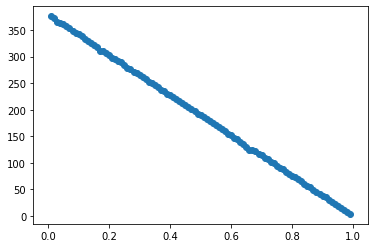

In [216]:
plist = []
vlist = []
for i in range (1,100):
    
    zz=val_batch.loc[:,val_batch.isna().sum()>val_batch.isna().sum().quantile(i/100)].columns.values
    plist.append(i/100)
    vlist.append(len(zz))
    
plt.scatter(plist,vlist)

In [228]:
#val_batch.drop(columns=delete_cols, inplace = True)
val_batch=val_batch.loc[False==val_batch.isna().any(axis=1),:]

In [255]:
# once only to save time
conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=password")
cur = conn.cursor()

cur.execute("SELECT * FROM data TABLESAMPLE BERNOULLI(5);")
val_batch = cur.fetchall()
cur.close()
conn.close()

val_batch = pd.DataFrame(val_batch, columns = pd.DataFrame(column_names)[0])
val_batch.replace("EMPTY", np.nan, inplace = True)
val_batch.drop(columns=identifiers, inplace = True)
val_batch = val_batch[False == val_batch["ret_exc_lead1m"].isnull()]



In [259]:
X_val_batch

,0,1,2,3,4,5,6,7,8,9,...,481,482,483,484,485,486,487,488,489,490
0,0.270006,0.616268,0.614537,0.889855,0.889855,0.891098,0.900855,0.327238,0.119122,0.242768,...,0.314815,0.314815,0.619119,0.0,0.946947,0.394394,0.000000,0.666667,0.376877,0.277277
1,0.083130,0.062072,0.061091,0.127694,0.127694,0.122157,0.140623,0.052177,0.078007,0.294970,...,0.314815,0.314815,0.619119,0.0,0.946947,0.394394,0.000000,0.666667,0.376877,0.277277
2,0.736763,0.904569,0.901883,0.942353,0.942353,0.945712,0.949003,0.909945,0.706564,0.162829,...,0.314815,0.314815,0.619119,0.0,0.946947,0.394394,0.000000,0.666667,0.376877,0.277277
3,0.872793,0.926812,0.926584,0.862798,0.862798,0.850648,0.859840,0.895038,0.788793,0.616153,...,0.314815,0.314815,0.619119,0.0,0.946947,0.394394,0.000000,0.666667,0.376877,0.277277
4,0.090079,0.234805,0.232698,0.572573,0.572573,0.621191,0.589874,0.037066,0.022950,0.071108,...,0.314815,0.314815,0.619119,0.0,0.946947,0.394394,0.000000,0.666667,0.376877,0.277277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,0.793802,0.745054,0.742796,0.555385,0.555385,0.537524,0.559688,0.000000,0.000000,0.657090,...,0.061562,0.000000,0.938939,0.0,0.228228,0.142643,0.528529,0.802803,0.733734,0.134134
2330,0.857986,0.760795,0.758566,0.481947,0.481947,0.450607,0.505775,0.000000,0.000000,0.529989,...,0.061562,0.000000,0.938939,0.0,0.228228,0.142643,0.528529,0.802803,0.733734,0.134134
2331,0.964639,0.865542,0.864202,0.345782,0.345782,0.318538,0.368198,0.610694,0.761628,0.592665,...,0.061562,0.000000,0.938939,0.0,0.228228,0.142643,0.528529,0.802803,0.733734,0.134134
2332,0.442278,0.663397,0.661968,0.812899,0.812899,0.802238,0.828281,0.686671,0.507499,0.447593,...,0.061562,0.000000,0.938939,0.0,0.228228,0.142643,0.528529,0.802803,0.733734,0.134134


In [257]:
val_batch = pd.merge(val_batch,macro_data, on ="eom" )
val_batch.drop(columns=["eom"], inplace = True)
val_batch.drop(columns=delete_cols, inplace = True)
val_batch=val_batch.loc[False==val_batch.isna().any(axis=1),:]
X_val_batch=quantile_transform(np.array(val_batch.drop(columns=['ret_exc_lead1m'])), n_quantiles=1000)
X_val_batch=pd.DataFrame(X_val_batch)
Y_val_batch = val_batch["ret_exc_lead1m"].astype(float)

# X_val_batch.fillna(X_val_batch.median(), inplace=True)

C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


In [233]:
val_batch=None
X_val_batch=None
Y_val_batch=None

In [261]:
for i in range(1,4):
    
    print("Loop: "+str(i))
    
    # import Dataset
    # pull random draws
    conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=password")
    cur = conn.cursor()

    cur.execute("SELECT * FROM data TABLESAMPLE BERNOULLI(10);")
    train_batch = cur.fetchall()
    print("got data")

    cur.close()
    conn.close()

    train_batch = pd.DataFrame(train_batch, columns = pd.DataFrame(column_names)[0])
    
    
    #preprocess
    train_batch.replace("EMPTY", np.nan, inplace = True)
    
    # drop identifiers, cols with lots of nan and drop nan Y values
    train_batch.drop(columns=identifiers, inplace = True)
    train_batch = train_batch[False == train_batch["ret_exc_lead1m"].isnull()]

    


    # not in loop, only once! define delete_cols after text conversion
    #used once only
    #train_batch.loc[:,train_batch.isna().sum()>train_batch.isna().sum().quantile(0.1)].columns.values

    
    #np.savetxt("Networks\delete_cols.csv", delete_cols, delimiter=",")
    # join macro
    train_batch = pd.merge(train_batch,macro_data, on ="eom")
    train_batch.drop(columns=["eom"], inplace = True)

    
    # for the whole dataset the same columns should be dropped
    #train_batch.drop(columns=delete_cols, inplace = True)
    #val_batch.drop(columns=delete_cols, inplace = True)
    
    # for the whole dataset the same columns should be dropped
    train_batch.drop(columns=delete_cols, inplace = True)
    

    # choose this or fillna: drop all rows with nan entries
    train_batch=train_batch.loc[False==train_batch.isna().any(axis=1),:]
    
    
    # percentile scaling before median filling
    X_train_batch=quantile_transform(np.array(train_batch.drop(columns=['ret_exc_lead1m'])), n_quantiles=1000)
    # transform back to DF to make fillna possible
    X_train_batch=pd.DataFrame(X_train_batch)
    Y_train_batch = train_batch["ret_exc_lead1m"].astype(float)
    

    # fill with median or drop?? drop a mix of cols and rows??
    #X_train_batch.fillna(X_train_batch.median(), inplace=True)
    

    # alternative to fillna(): dropna
    # X_train_batch.drop(train_batch.isna().any(axis=1),axis = 0, inplace=True)
    # X_val_batch.drop(train_batch.isna().any(axis=1),axis = 0, inplace=True)
    
    # optimizer
    batch_size = 200
    num_epochs = 50
    opt=Adamax(lr=0.001)
    # turn on discriminator
    network.layers[1].trainable = True
    network.layers[2].trainable = True
    network.layers[3].trainable = True
    network.layers[5].trainable = True
    network.layers[7].trainable = True

    # turn of adverse
    network.layers[4].trainable = False
    network.layers[6].trainable = False

    network.compile(optimizer=opt,\
                       loss=custom_loss)
    history=network.fit(X_train_batch, Y_train_batch, \
                        epochs=num_epochs, batch_size=batch_size)
    
    # Adversarial
    # turn of discriminator
    network.layers[1].trainable = False
    network.layers[2].trainable = False
    network.layers[3].trainable = False
    network.layers[5].trainable = False
    network.layers[7].trainable = False

    # turn on adverse
    network.layers[4].trainable = True
    network.layers[6].trainable = True
    opt=SGD(lr=0.01)
    network.compile(optimizer=opt,\
                       loss=custom_loss_adverse)
    history=network.fit(X_train_batch, Y_train_batch, epochs=num_epochs, batch_size=128)
    
    
    
    # optimizer again
    opt=Adamax(lr=0.001)
    # turn on discriminator
    network.layers[1].trainable = True
    network.layers[2].trainable = True
    network.layers[3].trainable = True
    network.layers[5].trainable = True
    network.layers[7].trainable = True

    # turn of adverse
    network.layers[4].trainable = False
    network.layers[6].trainable = False

    network.compile(optimizer=opt,\
                       loss=custom_loss)
    history=network.fit(X_train_batch, Y_train_batch, \
                        epochs=num_epochs, batch_size=batch_size)
                        #callbacks=[CustomCallback()], \
                        #validation_data=(X_val_batch, Y_val_batch))
    


Loop: 1
got data


C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


Epoch 1/50
4800/4800 [==============================] - 0s 58us/step - loss: 2287.6189
Epoch 2/50
4800/4800 [==============================] - 0s 30us/step - loss: 2103.6293
Epoch 3/50
4800/4800 [==============================] - 0s 30us/step - loss: 4387.7837
Epoch 4/50
4800/4800 [==============================] - 0s 31us/step - loss: 2071.3343
Epoch 5/50
4800/4800 [==============================] - 0s 30us/step - loss: 1690.9880
Epoch 6/50
4800/4800 [==============================] - 0s 31us/step - loss: 1834.6216
Epoch 7/50
4800/4800 [==============================] - 0s 30us/step - loss: 2102.4191
Epoch 8/50
4800/4800 [==============================] - 0s 29us/step - loss: 2169.8942
Epoch 9/50
4800/4800 [==============================] - 0s 29us/step - loss: 645.6185
Epoch 10/50
4800/4800 [==============================] - 0s 29us/step - loss: 1520.3692
Epoch 11/50
4800/4800 [==============================] - 0s 30us/step - loss: 1332.0955
Epoch 12/50
4800/4800 [===================

C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


Epoch 1/50
4621/4621 [==============================] - 0s 56us/step - loss: 25.5092
Epoch 2/50
4621/4621 [==============================] - 0s 32us/step - loss: 8.5109
Epoch 3/50
4621/4621 [==============================] - 0s 31us/step - loss: 11.8602
Epoch 4/50
4621/4621 [==============================] - 0s 31us/step - loss: 9.1795
Epoch 5/50
4621/4621 [==============================] - 0s 33us/step - loss: 12.3103
Epoch 6/50
4621/4621 [==============================] - 0s 31us/step - loss: 11.6379
Epoch 7/50
4621/4621 [==============================] - 0s 30us/step - loss: 14.8050
Epoch 8/50
4621/4621 [==============================] - 0s 33us/step - loss: 9.4632
Epoch 9/50
4621/4621 [==============================] - 0s 32us/step - loss: 7.6149
Epoch 10/50
4621/4621 [==============================] - 0s 31us/step - loss: 7.0847
Epoch 11/50
4621/4621 [==============================] - 0s 32us/step - loss: 8.8178
Epoch 12/50
4621/4621 [==============================] - 0s 32us/step

Epoch 47/50
4621/4621 [==============================] - 0s 33us/step - loss: -0.4173
Epoch 48/50
4621/4621 [==============================] - 0s 38us/step - loss: -0.1808
Epoch 49/50
4621/4621 [==============================] - 0s 32us/step - loss: -0.2374
Epoch 50/50
4621/4621 [==============================] - 0s 32us/step - loss: -0.3845
Epoch 1/50
4621/4621 [==============================] - 0s 56us/step - loss: 0.9488
Epoch 2/50
4621/4621 [==============================] - 0s 30us/step - loss: 0.6382
Epoch 3/50
4621/4621 [==============================] - 0s 30us/step - loss: 0.5585
Epoch 4/50
4621/4621 [==============================] - 0s 30us/step - loss: 0.5351
Epoch 5/50
4621/4621 [==============================] - 0s 30us/step - loss: 0.1880
Epoch 6/50
4621/4621 [==============================] - 0s 30us/step - loss: 0.2844
Epoch 7/50
4621/4621 [==============================] - 0s 30us/step - loss: 0.3994
Epoch 8/50
4621/4621 [==============================] - 0s 30us/step

C:\Users\Vincent\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


Epoch 1/50
4610/4610 [==============================] - 0s 57us/step - loss: 0.0234
Epoch 2/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0194
Epoch 3/50
4610/4610 [==============================] - 0s 31us/step - loss: 0.0175
Epoch 4/50
4610/4610 [==============================] - 0s 29us/step - loss: 0.0157
Epoch 5/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0117
Epoch 6/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0216
Epoch 7/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0167
Epoch 8/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 9/50
4610/4610 [==============================] - 0s 32us/step - loss: 0.0213
Epoch 10/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0089
Epoch 11/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0155
Epoch 12/50
4610/4610 [==============================] - 0s 30us/step - lo

4610/4610 [==============================] - 0s 33us/step - loss: -0.0237
Epoch 48/50
4610/4610 [==============================] - 0s 32us/step - loss: -0.0231
Epoch 49/50
4610/4610 [==============================] - 0s 32us/step - loss: -0.0224
Epoch 50/50
4610/4610 [==============================] - 0s 33us/step - loss: -0.0230
Epoch 1/50
4610/4610 [==============================] - 0s 58us/step - loss: 0.0140
Epoch 2/50
4610/4610 [==============================] - 0s 31us/step - loss: 0.0141
Epoch 3/50
4610/4610 [==============================] - 0s 32us/step - loss: 0.0139
Epoch 4/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0115
Epoch 5/50
4610/4610 [==============================] - 0s 30us/step - loss: 0.0279
Epoch 6/50
4610/4610 [==============================] - 0s 35us/step - loss: 0.0118
Epoch 7/50
4610/4610 [==============================] - 0s 32us/step - loss: 0.0122
Epoch 8/50
4610/4610 [==============================] - 0s 31us/step - loss: 0.0

In [262]:
network.save('Networks\prototype_03.h5')

In [263]:
y_pred=network.predict(X_train_batch)
y_pred[:,0].min()/y_pred[:,0].max()

0.99482024

In [264]:
# 1-w*R is the SDF
(1-sum(y_pred[:,0]*Y_train_batch))

0.9332940108001208

In [265]:
# Loss1
# M * R
# (1-w *R) * R 
w=network.predict(X_train_batch)
np.mean(((1-sum(w[:,0]*Y_train_batch)))*Y_train_batch)

0.01690789458299724

(array([ 285., 1531., 1196.,  743.,  481.,  216.,  101.,   40.,   11.,
           6.]),
 array([0.00079715, 0.00079757, 0.00079798, 0.0007984 , 0.00079881,
        0.00079923, 0.00079964, 0.00080006, 0.00080047, 0.00080089,
        0.0008013 ], dtype=float32),
 <a list of 10 Patch objects>)

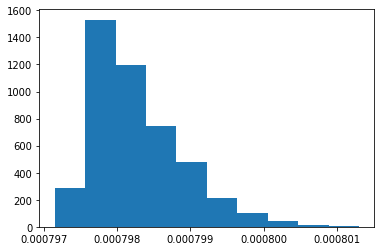

In [266]:
plt.hist(w[:,0])

In [277]:
# Loss2
# M * R * G
# (1-w *R) * R * G
w=network.predict(X_train_batch)
np.mean(((1-sum(w[:,0]*Y_train_batch)) )*Y_train_batch*w[:,1])

0.016907876549368282

In [284]:
X_train_batch

,0,1,2,3,4,5,6,7,8,9,...,481,482,483,484,485,486,487,488,489,490
0,0.955956,0.939835,0.939118,0.680805,0.680805,0.700464,0.703253,0.940635,0.936338,0.167615,...,0.319820,0.335836,0.633133,0.0,0.942442,0.439439,0.000000,0.668168,0.392893,0.297798
1,0.025199,0.112005,0.111096,0.487507,0.487507,0.470883,0.505012,0.105762,0.055216,0.522074,...,0.319820,0.335836,0.633133,0.0,0.942442,0.439439,0.000000,0.668168,0.392893,0.297798
2,0.364618,0.509344,0.506680,0.667790,0.667790,0.670671,0.692196,0.438901,0.313188,0.289286,...,0.319820,0.335836,0.633133,0.0,0.942442,0.439439,0.000000,0.668168,0.392893,0.297798
3,0.600104,0.754201,0.752495,0.817787,0.817787,0.827259,0.834909,0.706725,0.532216,0.168796,...,0.319820,0.335836,0.633133,0.0,0.942442,0.439439,0.000000,0.668168,0.392893,0.297798
4,0.256251,0.355064,0.353086,0.505506,0.505506,0.517626,0.533033,0.399981,0.355329,0.179766,...,0.319820,0.335836,0.633133,0.0,0.942442,0.439439,0.000000,0.668168,0.392893,0.297798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.408520,0.100088,0.099074,0.055140,0.055140,0.053991,0.061061,0.153951,0.388569,0.105793,...,0.068569,0.000000,0.926927,0.0,0.239239,0.147147,0.549049,0.805305,0.748248,0.147147
4606,0.650000,0.626257,0.624316,0.536227,0.536227,0.520967,0.546531,0.692640,0.728856,0.581217,...,0.068569,0.000000,0.926927,0.0,0.239239,0.147147,0.549049,0.805305,0.748248,0.147147
4607,0.471909,0.672309,0.669996,0.814544,0.814544,0.798404,0.828129,0.699171,0.522599,0.476626,...,0.068569,0.000000,0.926927,0.0,0.239239,0.147147,0.549049,0.805305,0.748248,0.147147
4608,0.439410,0.551606,0.550080,0.647831,0.647831,0.624559,0.649445,0.426744,0.317138,0.732179,...,0.068569,0.000000,0.926927,0.0,0.239239,0.147147,0.549049,0.805305,0.748248,0.147147


In [286]:
Return_List = []
for i in range(0,90):
    w=network.predict(X_train_batch.iloc[0+i*50:50+i*50])
    Return_List.append(sum(w[:,0]*Y_train_batch.iloc[0+i*50:50+i*50]))
(np.array(Return_List).mean()/np.array(Return_List).std())

0.186228046304332

In [191]:
Return_List_BH = []
for i in range(0,18):
    Return_List_BH.append(Y_train_batch.iloc[0+i*500:500+i*500])


np.array(Return_List_BH)[0].mean()/np.array(Return_List_BH)[0].std()

-0.2632568065333715

In [ ]:
# MSCI monthly sharpe
0.7/np.sqrt(12)

In [49]:
# sharpe... maybe not transferable to "invest once", need portfolio
(w[:,0]*Y_val_batch).mean()/(w[:,0]*Y_val_batch).std()

0.08501535852639515

In [ ]:
Y_val_batch.mean()/Y_val_batch.std()

In [ ]:
# /w[:,0].sum() to adjust for weight sum <1 -> ptf of 100%
((w[:,0]/w[:,0].sum())*y_features_set).sum()

# annualized
(((w[:,0]/w[:,0].sum())*y_features_set).sum()+1)**3-1

In [ ]:
# return
print((w[:,0]*Y_val_batch).sum())

# sum of weights
print(w[:,0].sum())

In [ ]:
epochs = range(1, len(acc[0]) + 1)
colorlist = ['blue','cyan','purple','pink','orange','red','brown','gray','olive','green']
plt.figure(figsize=(12,6))
i=0
while i <  len(acc):
    plt.plot(epochs, acc[i] , 'bo', label='Training acc', color = colorlist[i])
    plt.plot(epochs, val_acc[i], 'b', label='Validation acc', color=colorlist[i])
    
    ax= plt.gca()
    ax.tick_params(direction='in')
    i+=1
#plt.ylim(ymax = 1, ymin = 0.6)
plt.title('Training and validation accuracy')

In [ ]:
weights = network.predict(X)[:,0]
g_i = network.predict(X)[:,1]
excess_returns = Y
(weights * excess_returns).mean()

In [ ]:
reload.predict(X_val_batch)

In [ ]:
network.predict(X_val_batch)